In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg

%matplotlib inline 
%reload_ext autoreload 
%autoreload 2

In [ ]:
# import data 

#Please note: the experiment had to be repeated several times, therefore has_website has most likely been wrongly set
# Instead use: har_file

db = psycopg.connect(dbname='web_performance_final')
#db = psycopg.connect(dbname='complexity_analysis')
cursor = db.cursor()
#res = cursor.execute("SELECT dns, number_queried_servers  FROM websites ORDER BY number_queried_servers DESC LIMIT 50")
#print(cursor.fetchall())

# import data 
website_df = pd.read_sql_query("SELECT * FROM websites", db)
mime_types_df = pd.read_sql_query("SELECT * FROM mime_types", db)
measurements_df = pd.read_sql_query("SELECT * FROM measurements", db)

In [7]:
cursor.execute("SELECT COUNT(*) FROM websites")
domains_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM websites WHERE har_file=True")
website_count = cursor.fetchone()[0]
#website_count = 719281

cursor.execute("SELECT COUNT(*) FROM websites WHERE har_file=True AND has_error=True")
error_pages = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM websites WHERE har_file=True AND has_error=False")
none_error_pages = cursor.fetchone()[0]

print('domains offering a website ', website_count, '/', domains_count)
print('error encounter, no page provided ', domains_count-website_count, '/', domains_count)
print('domains displaying an error page ', error_pages, '/', domains_count)
print('domains displaying no error page ', none_error_pages, '/', domains_count)


domains offering a website  572345 / 1000000
error encounter, no page provided  427655 / 1000000
domains displaying an error page  572345 / 1000000
domains displaying no error page  0 / 1000000


domains offering a website  572345 / 1000000
error encounter, no page provided  0 / 1000000
domains displaying an error page  572345 / 1000000


In [10]:
# website complexity statisitics
median_objects = website_df['number_objects_loaded'].median()
mean_objects = website_df['number_objects_loaded'].mean()

median_queried_servers = website_df['number_queried_servers'].median()
mean_queried_servers = website_df['number_queried_servers'].mean()

median_non_origin_servers = website_df['number_non_origin_servers'].median()
mean_non_origin_servers = website_df['number_non_origin_servers'].mean()

median_mime_types = website_df['number_mime_types'].median()
mean_mime_types = website_df['number_mime_types'].mean()

median_bytes_downladed = website_df['bytes_downladed'].div(1024).div(1024).median()
mean_bytes_downladed = website_df['bytes_downladed'].div(1024).div(1024).mean()


print('median number of objects ', median_objects)
print('mean number of objects ', mean_objects)
print('median queried servers ', median_queried_servers)
print('mean queried servers ', mean_queried_servers)
print('median non origin servers ', median_non_origin_servers)
print('mean non origin servers ', mean_non_origin_servers)
print('median number of mime types ', median_mime_types)
print('mean number of mime types ', mean_mime_types)
print('median bytes downloaded ', median_bytes_downladed, ' MB')
print('mean bytes downloaded ', mean_bytes_downladed, ' MB')


median number of objects  42.0
mean number of objects  62.98801441995548
median queried servers  7.0
mean queried servers  9.634270889958167
median non origin servers  5.0
mean non origin servers  8.44912628027155
median number of mime types  11.0
mean number of mime types  10.818130883479474
median bytes downloaded  1.2021608352661133  MB
mean bytes downloaded  2.842003255631863  MB


In [16]:
# add needed performance metrics

# clean measurements
cleaned_measurements_df = measurements_df[measurements_df['error'] == '']
cleaned_measurements_df = cleaned_measurements_df[cleaned_measurements_df['loadeventend'] != 0]
cleaned_measurements_df = cleaned_measurements_df[cleaned_measurements_df['firstcontentfulpaint'] != 0]
warmed_up_measurements_df = cleaned_measurements_df[cleaned_measurements_df['cachewarming'] == 0]

# neeeded columns
warmed_up_measurements_df['web_duration'] = warmed_up_measurements_df['loadeventend'] - warmed_up_measurements_df['fetchstart']


# find intersect measurements
domains_counted = warmed_up_measurements_df.groupby('domain', as_index=False)['domain'].agg({'count':'count'})
intersect_domains = domains_counted[domains_counted['count'] == 3]
intersect_measurements = warmed_up_measurements_df[warmed_up_measurements_df['domain'].isin(intersect_domains['domain'])]


# create penalty columns
scatterplot_df = intersect_measurements[['domain','web_duration', 'protocol', 'firstcontentfulpaint']]

q_h_scatterplot_df = scatterplot_df[scatterplot_df['protocol'] != 'udp']
u_scatterplot_df = scatterplot_df[scatterplot_df['protocol'] == 'udp']
u_scatterplot_df = u_scatterplot_df.rename(columns={'web_duration': 'web_duration_udp', 'firstcontentfulpaint': 'firstcontentfulpaint_udp'})

q_h_scatterplot_df['performance_penalty_web_duration'] = q_h_scatterplot_df['web_duration'] 
q_h_scatterplot_df['performance_penalty_firstcontentfulpaint'] = q_h_scatterplot_df['firstcontentfulpaint']

q_h_scatterplot_merge_df = pd.merge(q_h_scatterplot_df, u_scatterplot_df, how='inner', on='domain')

q_h_scatterplot_merge_df['performance_penalty_web_duration'] = q_h_scatterplot_merge_df['performance_penalty_web_duration'] - q_h_scatterplot_merge_df['web_duration_udp'] 
q_h_scatterplot_merge_df['performance_penalty_firstcontentfulpaint'] = q_h_scatterplot_merge_df['performance_penalty_firstcontentfulpaint'] - q_h_scatterplot_merge_df['firstcontentfulpaint_udp']

q_h_scatterplot_merge_df = q_h_scatterplot_merge_df.rename(columns={'protocol_x': 'protocol'})


/var/folders/gg/mshnyrc13_xds3zrlmd3_nkc0000gn/T/ipykernel_5854/1953754078.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  warmed_up_measurements_df['web_duration'] = warmed_up_measurements_df['loadeventend'] - warmed_up_measurements_df['fetchstart']
/var/folders/gg/mshnyrc13_xds3zrlmd3_nkc0000gn/T/ipykernel_5854/1953754078.py:14: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  domains_counted = warmed_up_measurements_df.groupby('domain', as_index=False)['domain'].agg({'count':'count'})
/var/folders/gg/mshnyrc13_xds3zrlmd3_nkc0000gn/T/ipykernel_5854/1953754078.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [ ]:
# merge penalty columns with website table 


In [48]:
q_scatterplot_merge_df = q_h_scatterplot_merge_df[q_h_scatterplot_merge_df['protocol'] == 'quic'] 
h_scatterplot_merge_df = q_h_scatterplot_merge_df[q_h_scatterplot_merge_df['protocol'] == 'h3']

website_df_insersect = pd.merge(website_df, q_scatterplot_merge_df, how='inner',left_on='dns', right_on='domain')
website_df_insersect = website_df_insersect.rename(columns={'web_duration': 'web_duration_quic', 'firstcontentfulpaint': 'firstcontentfulpaint_quic', 'performance_penalty_web_duration': 'performance_penalty_web_duration_quic', 'performance_penalty_firstcontentfulpaint': 'performance_penalty_firstcontentfulpaint_quic'})
website_df_insersect = website_df_insersect.drop(['protocol', 'protocol_y'], axis=1)
website_df_insersect = pd.merge(website_df_insersect, h_scatterplot_merge_df, how='inner',left_on='dns', right_on='domain')
website_df_insersect = website_df_insersect.rename(columns={'web_duration': 'web_duration_h3', 'firstcontentfulpaint': 'firstcontentfulpaint_h3', 'performance_penalty_web_duration': 'performance_penalty_web_duration_h3', 'performance_penalty_firstcontentfulpaint': 'performance_penalty_firstcontentfulpaint_h3'})     
website_df_insersect = website_df_insersect.drop(['protocol','protocol_y', 'domain_x', 'web_duration_udp_x', 'firstcontentfulpaint_udp_x', 'domain_y'], axis=1)                                
website_df_insersect = website_df_insersect.rename(columns={'web_duration_udp_y': 'web_duration_udp', 'firstcontentfulpaint_udp_y': 'firstcontentfulpaint_udp'})    


In [50]:
# correletion between website properties and DoE impact on loading time
website_df_insersect_cleaned_corr = website_df_insersect.drop(['has_website','has_error', 'har_file', '_id'], axis=1)
correlation_df = website_df_insersect_cleaned_corr.corr(numeric_only=True)


In [67]:
intersect_domains

,domain,count
7,001.bj,3
16,004gmbh.de,3
23,007cctv.com,3
25,007onlinecasino.club,3
26,007onlinecasino.net,3
...,...,...
429028,zzhczs.com,3
429036,zzkaizhi.com,3
429074,zztuoying.com,3
429076,zzwangu.com,3


In [61]:
correlation_performance_df = correlation_df.drop(['web_duration_quic', 'firstcontentfulpaint_quic', 'web_duration_h3', 'firstcontentfulpaint_h3', 'web_duration_udp', 'firstcontentfulpaint_udp'], axis=1)   
correlation_loading_df = correlation_df.drop(['performance_penalty_web_duration_quic', 'performance_penalty_firstcontentfulpaint_quic', 'performance_penalty_web_duration_h3', 'performance_penalty_firstcontentfulpaint_h3'], axis=1)

correlation_performance_df = correlation_performance_df.drop(['web_duration_quic', 'firstcontentfulpaint_quic', 'web_duration_h3', 'firstcontentfulpaint_h3', 'web_duration_udp', 'firstcontentfulpaint_udp'], axis=0)   
correlation_loading_df = correlation_loading_df.drop(['performance_penalty_web_duration_quic', 'performance_penalty_firstcontentfulpaint_quic', 'performance_penalty_web_duration_h3', 'performance_penalty_firstcontentfulpaint_h3'], axis=0)  


<Axes: >

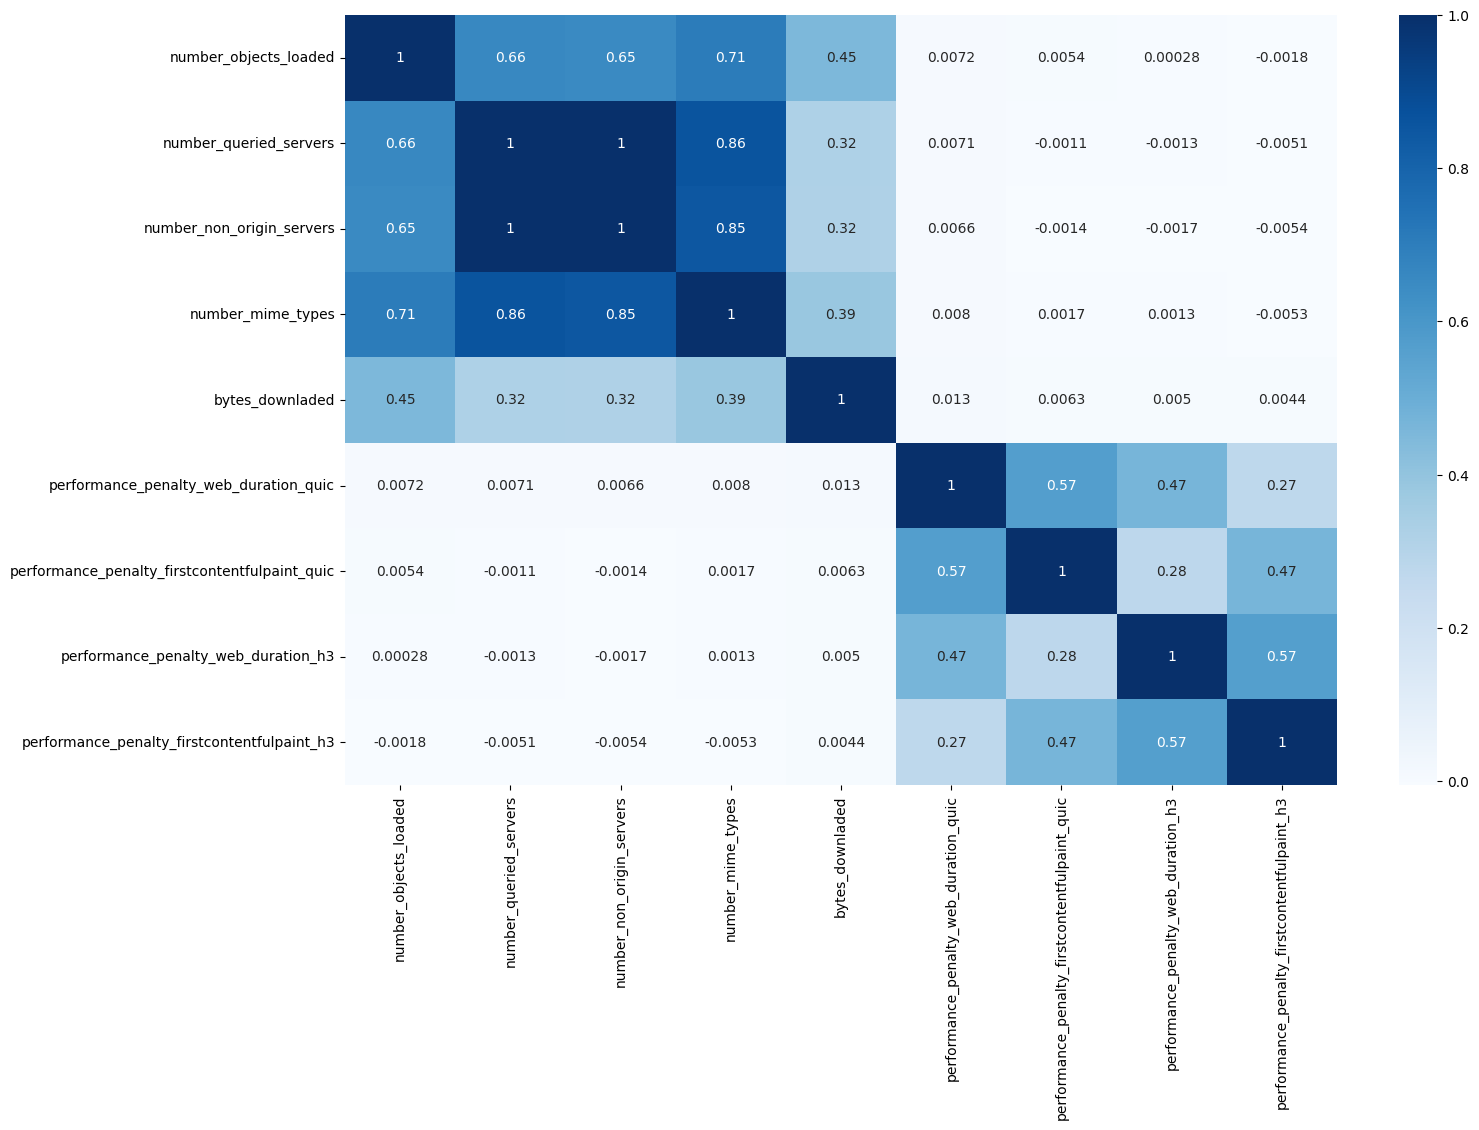

In [66]:
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_performance_df, annot=True, cmap="Blues")

<Axes: >

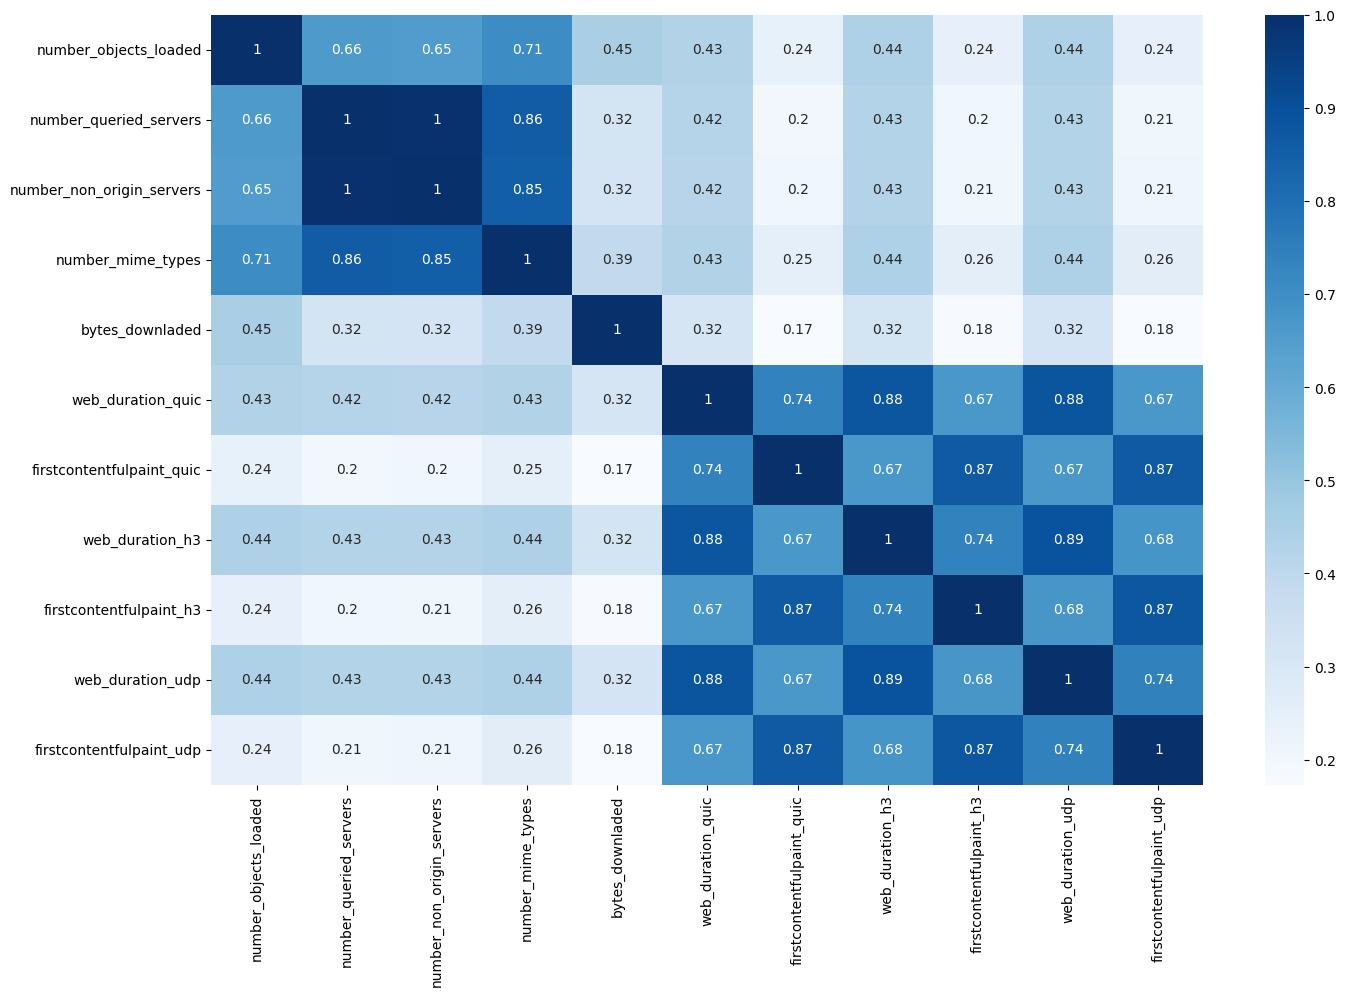

In [65]:
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_loading_df, annot=True, cmap="Blues")

In [124]:
correlation_loading_df.tail(6)

,number_objects_loaded,number_queried_servers,number_non_origin_servers,number_mime_types,bytes_downladed,web_duration_quic,firstcontentfulpaint_quic,web_duration_h3,firstcontentfulpaint_h3,web_duration_udp,firstcontentfulpaint_udp
web_duration_quic,0.432906,0.422468,0.421495,0.432454,0.318297,1.000000,0.738469,0.880528,0.668388,0.880566,0.670114
firstcontentfulpaint_quic,0.239124,0.199441,0.204120,0.253958,0.173400,0.738469,1.000000,0.670216,0.865227,0.668804,0.866924
web_duration_h3,0.440639,0.429256,0.428299,0.440231,0.322286,0.880528,0.670216,1.000000,0.741236,0.891844,0.678195
firstcontentfulpaint_h3,0.241575,0.202598,0.207470,0.256985,0.176804,0.668388,0.865227,0.741236,1.000000,0.675384,0.874915
web_duration_udp,0.441568,0.430883,0.430100,0.440666,0.320755,0.880566,0.668804,0.891844,0.675384,1.000000,0.744235
firstcontentfulpaint_udp,0.244021,0.206454,0.211478,0.261290,0.175709,0.670114,0.866924,0.678195,0.874915,0.744235,1.000000


In [125]:
correlation_performance_df = correlation_performance_df.tail(4)
correlation_loading_df = correlation_loading_df.tail(6)

temp1 = correlation_performance_df.drop(['performance_penalty_web_duration_quic', 'performance_penalty_firstcontentfulpaint_quic', 'performance_penalty_web_duration_h3', 'performance_penalty_firstcontentfulpaint_h3'], axis=1)
temp2 = correlation_loading_df.drop(['web_duration_quic', 'firstcontentfulpaint_quic', 'web_duration_h3', 'firstcontentfulpaint_h3', 'web_duration_udp', 'firstcontentfulpaint_udp'], axis=1)

correlation_df = pd.concat([temp1, temp2])


<Axes: >

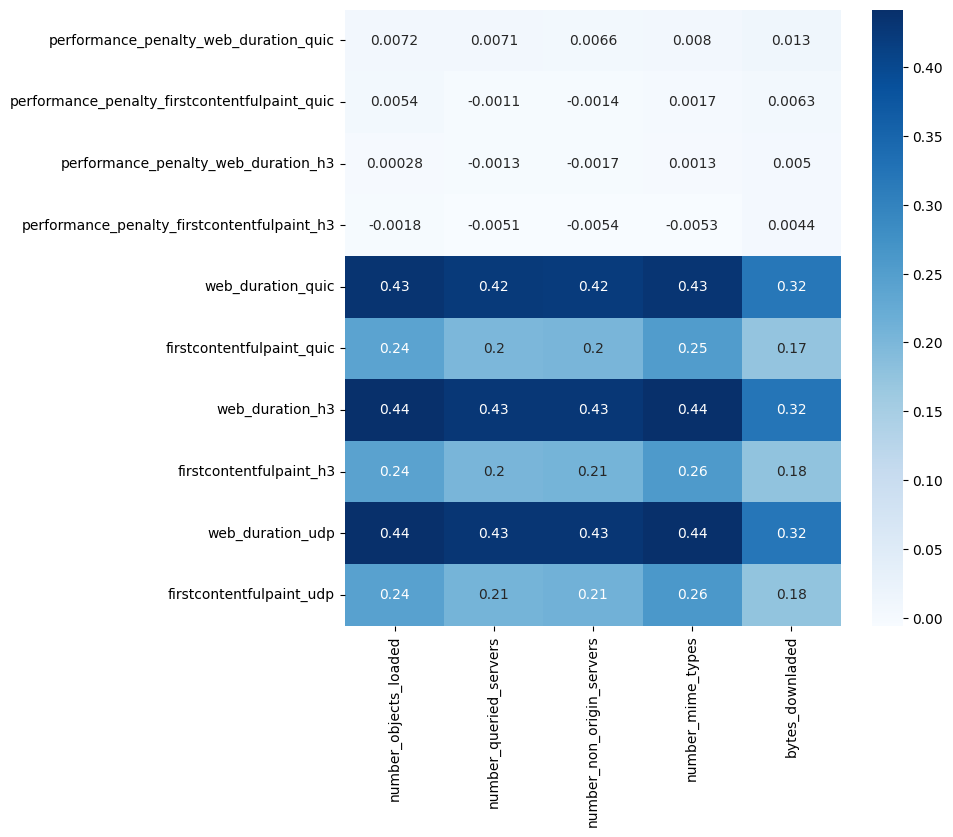

In [131]:
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_df, annot=True, cmap="Blues")

In [71]:
mime_type_list = list(mime_types_df['mime_type'].unique())
mime_type_set = set([x.split(';')[0] for x in mime_type_list])

{'', 'text/javascript  charset=utf-8', 'imag/x-icon', 'Application/JSON', 'ttf', 'video/m4v', 'Content-Type: image/png', 'application/ljson', 'image/x-png', 'text/vnd.trolltech.linguist', 'application/x-javascript, charset=UTF-8', 'application/fontwoff2', 'application/postscript', 'woff type', 'PNG32', 'font/x-webp', 'application/image/svg+xml', 'text/srt', '"font/woff2"', 'application/vnd.google.octet-stream-compressible', 'application/vnd.scaleofuniverse.dave', 'i', 'application/x-javascript', 'image/icon', 'image/JPG', 'image/x-icon', 'application/pgp-keys', 'application/schema+json', 'webp/image', 'text/richtext', 'image/vnd.microsoft.icon', 'image/bmp', 'vnd.travelcircus.campaign.collection+json', 'image/jfif', 'application/vnd.solid-v1.0+json', 'application/node', 'text/css,text/html', 'image/tif', 'application/linkset+json', 'application/json, charset=utf-8,text/html, charset=utf-8', 'application/vnd.microsoft.appconfig.kvset+json', '$contentType', 'javascript/vue', 'application

In [106]:
# correlation mime types

# filter for relevant ID of interesect websites
ids_df = website_df[['dns', '_id']]
ids_df = ids_df.rename(columns={'dns': 'domain'})
intersect_ids = pd.merge(intersect_domains, ids_df, how='inner', on='domain')
mime_types_intersect_df = mime_types_df[mime_types_df['website_id'].isin(intersect_ids['_id'])]

#clean mime types hard because everybody can write anything as mimetype name in there 
# instead --> look for most common types
mime_types_counted = mime_types_intersect_df.groupby('mime_type', as_index=False)['mime_type'].agg({'count':'count'})
mime_types_top_82 = mime_types_counted.sort_values(by=['count'], ascending=False).head(82) # all mimetypes which are seen more thna 100 times
mime_types_intersect_82_df = mime_types_intersect_df[mime_types_intersect_df['mime_type'].isin(mime_types_top_82['mime_type'])]

# add occurances of mime types to website_df_insersect
mime_types_intersect_82_df = mime_types_intersect_82_df.drop(['bytes_body_download', 'bytes_header_download'], axis=1)
pivoted_mime_types_intersect_82_df =  mime_types_intersect_82_df.pivot(index='website_id', columns='mime_type', values='occurences')
website_df_intersect_mime_types = pd.merge(website_df_insersect, pivoted_mime_types_intersect_82_df, how='inner', left_on='_id', right_on='website_id')

# drop unneccessary columns
website_df_intersect_mime_types = website_df_intersect_mime_types.drop(['dns', 'has_error', 'har_file', 'number_dns_queries', 'number_objects_loaded', 'number_queried_servers', 'number_non_origin_servers', 'bytes_downladed', 'number_mime_types', '_id', 'has_website'], axis=1)

# drop columns for performance 
website_df_intersect_mime_types_performance = website_df_intersect_mime_types.drop(['web_duration_quic', 'firstcontentfulpaint_quic', 'web_duration_h3', 'firstcontentfulpaint_h3', 'web_duration_udp', 'firstcontentfulpaint_udp'], axis=1)

# drop columns for loading time 
website_df_intersect_mime_types_loading = website_df_intersect_mime_types.drop(['performance_penalty_web_duration_quic', 'performance_penalty_firstcontentfulpaint_quic', 'performance_penalty_web_duration_h3', 'performance_penalty_firstcontentfulpaint_h3'], axis=1)


# make correlations
correlation_mime_types_performance_df = website_df_intersect_mime_types_performance.corr(numeric_only=True)
correlation_mime_types_loading_df = website_df_intersect_mime_types_loading.corr(numeric_only=True)


/var/folders/gg/mshnyrc13_xds3zrlmd3_nkc0000gn/T/ipykernel_5854/3017547977.py:11: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  mime_types_counted = mime_types_intersect_df.groupby('mime_type', as_index=False)['mime_type'].agg({'count':'count'})


In [115]:
correlation_mime_types_performance_df = correlation_mime_types_performance_df.head(4)

correlation_mime_types_loading_df = correlation_mime_types_loading_df.head(6)



In [112]:
correlation_mime_types_performance_df.head(4)

,performance_penalty_web_duration_quic,performance_penalty_firstcontentfulpaint_quic,performance_penalty_web_duration_h3,performance_penalty_firstcontentfulpaint_h3,,application/binary,application/font-sfnt,application/font-woff,application/font-woff2,application/javascript,...,text/json,text/plain,text/plain charset=UTF-8,text/plain; charset=UTF-8,text/plain; charset=utf-8,text/plain;charset=UTF-8,text/plain;charset=utf-8,text/x-component,video/mp4,video/webm
performance_penalty_web_duration_quic,1.000000,0.572114,0.472696,0.276997,-0.000851,0.030865,0.037592,-0.010475,0.000088,0.002006,...,0.010549,-0.002085,0.027082,0.002774,0.042117,0.023874,-0.065845,0.070416,0.016292,0.105630
performance_penalty_firstcontentfulpaint_quic,0.572114,1.000000,0.284637,0.474791,-0.003026,0.005074,-0.048452,-0.049865,0.019163,0.006692,...,0.110904,0.001835,0.128050,-0.018732,-0.005689,-0.009657,-0.095466,0.012719,0.000331,0.028861
performance_penalty_web_duration_h3,0.472696,0.284637,1.000000,0.571838,-0.008684,0.029592,-0.019662,0.009540,-0.016646,0.007152,...,0.056014,-0.004458,0.106618,0.027583,0.000580,0.027116,-0.083113,0.118540,0.019644,0.051320
performance_penalty_firstcontentfulpaint_h3,0.276997,0.474791,0.571838,1.000000,-0.005810,-0.001812,-0.040098,-0.044461,-0.015694,0.001961,...,0.115991,0.009820,0.186874,0.009935,-0.000472,-0.005030,-0.185107,0.013450,-0.016614,-0.023432


In [116]:
temp1 = correlation_mime_types_performance_df.drop(['performance_penalty_web_duration_quic', 'performance_penalty_firstcontentfulpaint_quic', 'performance_penalty_web_duration_h3', 'performance_penalty_firstcontentfulpaint_h3'], axis=1)

temp2 = correlation_mime_types_loading_df.drop(['web_duration_quic', 'firstcontentfulpaint_quic', 'web_duration_h3', 'firstcontentfulpaint_h3', 'web_duration_udp', 'firstcontentfulpaint_udp'], axis=1)

correlation_mime_types_df = pd.concat([temp1, temp2])


<Axes: >

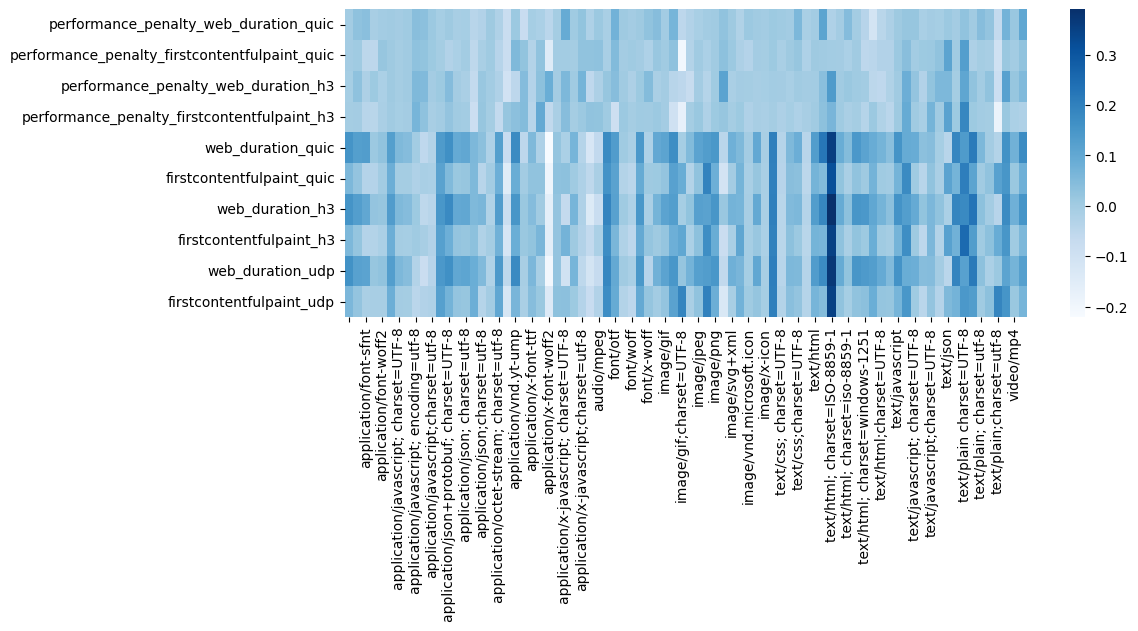

In [133]:
plt.figure(figsize=(11, 4))
#sns.heatmap(correlation_performance_df, annot=True, cmap="Blues")
sns.heatmap(correlation_mime_types_df, cmap="Blues")


<Axes: >

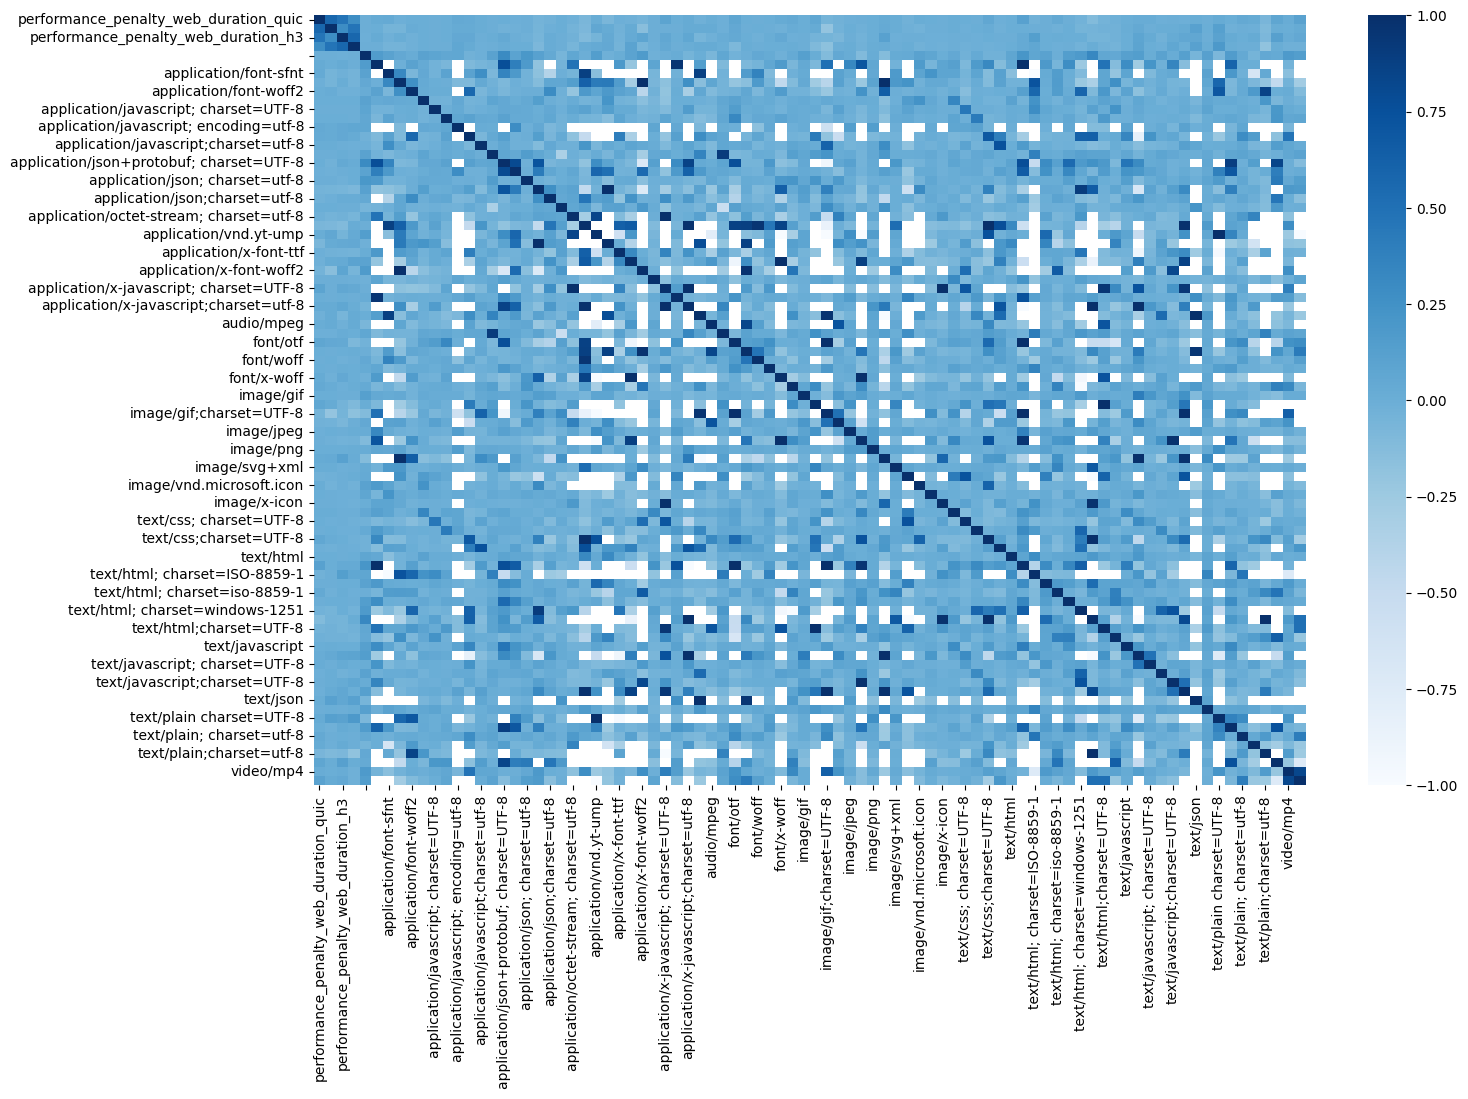

In [107]:
plt.figure(figsize=(16, 10))
#sns.heatmap(correlation_performance_df, annot=True, cmap="Blues")
sns.heatmap(correlation_mime_types_performance_df, cmap="Blues")

<Axes: >

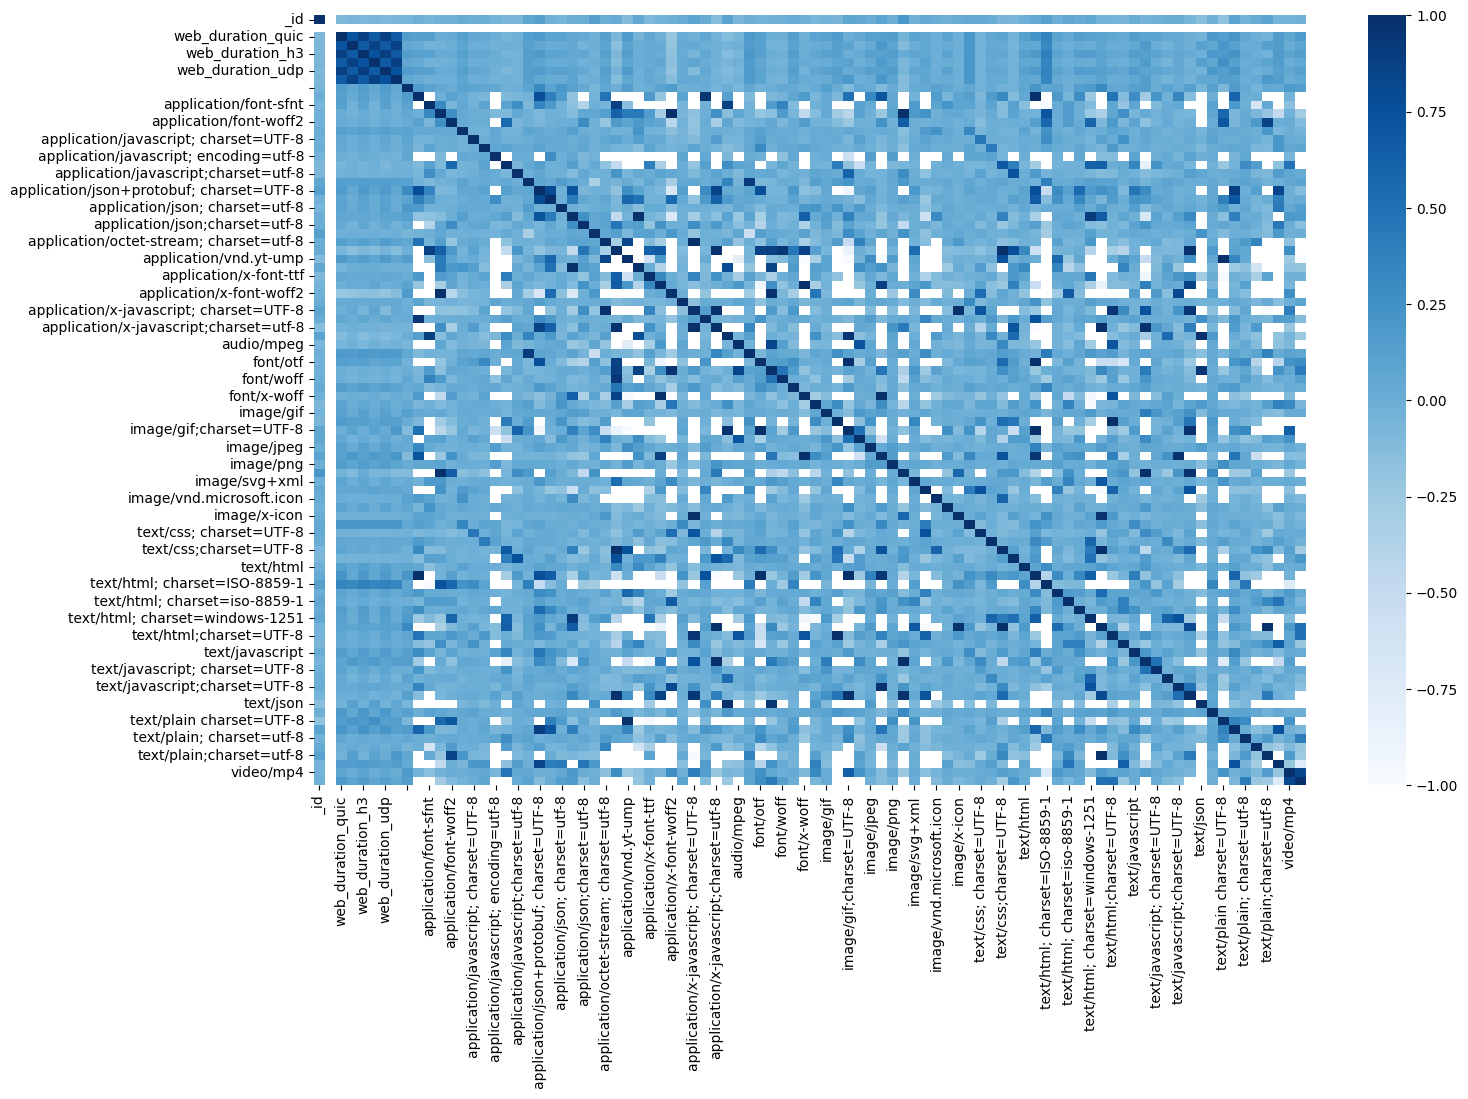

In [105]:
plt.figure(figsize=(16, 10))
#sns.heatmap(correlation_performance_df, annot=True, cmap="Blues")
sns.heatmap(correlation_mime_types_loading_df, cmap="Blues")

In [100]:
list(website_df_intersect_mime_types)
website_df_intersect_mime_types = website_df_intersect_mime_types.drop(['has_website', 'has_error', 'har_file', ], axis=1)


['_id',
 'has_website',
 'has_error',
 'dns',
 'number_dns_queries',
 'number_objects_loaded',
 'number_queried_servers',
 'number_non_origin_servers',
 'number_mime_types',
 'bytes_downladed',
 'har_file',
 'web_duration_quic',
 'firstcontentfulpaint_quic',
 'performance_penalty_web_duration_quic',
 'performance_penalty_firstcontentfulpaint_quic',
 'web_duration_h3',
 'firstcontentfulpaint_h3',
 'performance_penalty_web_duration_h3',
 'performance_penalty_firstcontentfulpaint_h3',
 'web_duration_udp',
 'firstcontentfulpaint_udp',
 '',
 'application/binary',
 'application/font-sfnt',
 'application/font-woff',
 'application/font-woff2',
 'application/javascript',
 'application/javascript; charset=UTF-8',
 'application/javascript; charset=utf-8',
 'application/javascript; encoding=utf-8',
 'application/javascript;charset=UTF-8',
 'application/javascript;charset=utf-8',
 'application/json',
 'application/json+protobuf; charset=UTF-8',
 'application/json; charset=UTF-8',
 'application/json

In [68]:
website_df

,_id,has_website,has_error,dns,number_dns_queries,number_objects_loaded,number_queried_servers,number_non_origin_servers,number_mime_types,bytes_downladed,har_file
0,940334,True,True,crohn-colitis-info.at,None,102.0,6.0,5.0,14.0,3646848.0,True
1,458600,True,True,robertaspizza.com,None,60.0,12.0,11.0,15.0,3256246.0,True
2,955456,True,True,techdifferences.com,None,40.0,12.0,10.0,15.0,950706.0,True
3,437664,True,True,ufabet.navy,None,24.0,3.0,1.0,5.0,604585.0,True
4,653103,True,True,eclecticrecipes.com,None,31.0,13.0,11.0,17.0,1352135.0,True
...,...,...,...,...,...,...,...,...,...,...,...
999995,585227,True,False,conflictarm.com,None,0.0,0.0,0.0,0.0,0.0,False
999996,766938,True,False,batepapocommulheres.com,None,0.0,0.0,0.0,0.0,0.0,False
999997,658198,True,False,nezavisim.tv,None,0.0,0.0,0.0,0.0,0.0,False
999998,564741,True,False,aare.edu.au,None,0.0,0.0,0.0,0.0,0.0,False


([<matplotlib.patches.Wedge at 0x7fb92e708c10>,
 [Text(-0.7778174593052023, 0.7778174593052024, 'websites'),
  Text(0.7778174593052022, -0.7778174593052025, 'non website domains')])

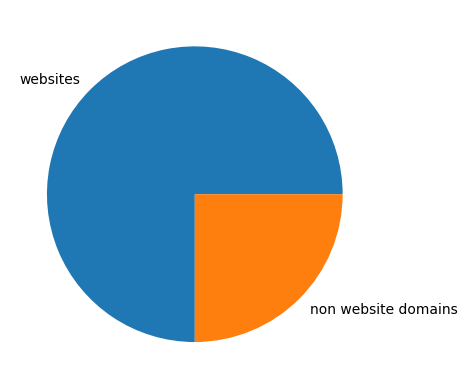

In [9]:
sample = len(website_df['number_objects_loaded'])
not_a_website = website_df['number_objects_loaded'].isna().sum()

plt.pie([sample-not_a_website, not_a_website], labels=['websites', 'non website domains']) 

In [16]:
website_df = website_df[website_df['number_objects_loaded'].notna()]
website_df['number_objects_loaded'].isna().sum()

0

In [18]:
# calculate in kb
website_df['bytes_downladed'] = website_df['bytes_downladed'].div(1000).round()

In [20]:
website_df

,_id,dns,number_dns_queries,number_objects_loaded,number_queried_servers,number_non_origin_servers,number_mime_types,bytes_downladed,alexa_category
0,1,google.com,None,34.0,8.0,4.0,13.0,1054.0,None
2,3,microsoft.com,None,94.0,16.0,8.0,22.0,3634.0,None
3,4,facebook.com,None,69.0,6.0,4.0,10.0,2659.0,None
5,6,googleapis.com,None,4.0,2.0,1.0,2.0,18.0,None
6,7,apple.com,None,62.0,5.0,2.0,16.0,9552.0,None
...,...,...,...,...,...,...,...,...,...
493,494,ft.com,None,143.0,19.0,11.0,19.0,1915.0,None
496,497,virtualearth.net,None,104.0,6.0,3.0,12.0,1532.0,None
497,498,trustpilot.com,None,141.0,16.0,13.0,19.0,2554.0,None
498,499,visualstudio.com,None,223.0,19.0,17.0,21.0,4909.0,None


[Text(0.5, 0, 'bytes downloaded in kB'), Text(0, 0.5, 'number of websites')]

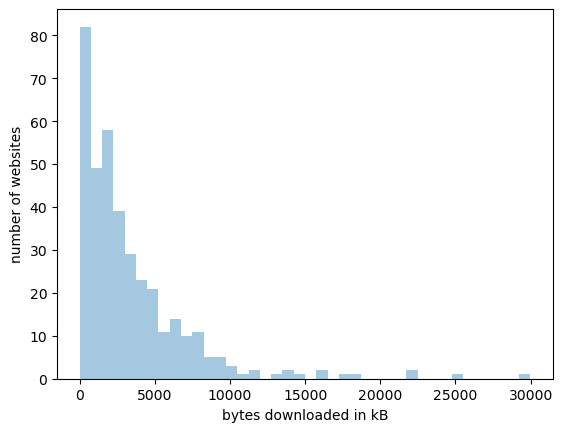

In [22]:
# number of bytes downloaded
diagram = sns.distplot(website_df['bytes_downladed'], kde=False, bins=40)
diagram.set(xlabel='bytes downloaded in kB', ylabel='number of websites')


[Text(0.5, 0, 'number of mime_types'), Text(0, 0.5, 'number of websites')]

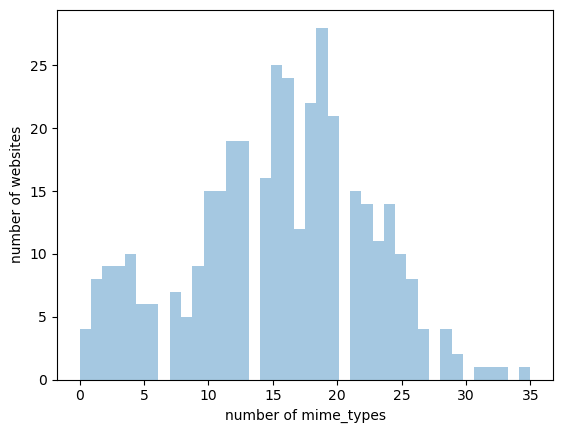

In [23]:
# number of bytes downloaded
diagram = sns.distplot(website_df['number_mime_types'], kde=False, bins=40)
diagram.set(xlabel='number of mime_types', ylabel='number of websites')

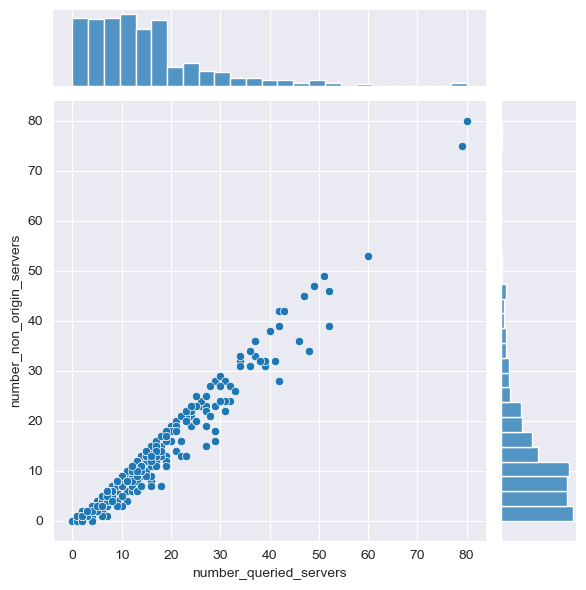

In [29]:
# queried servers compared to non origin servers
sns.set_style('darkgrid')
sns.jointplot(x='number_queried_servers', y='number_non_origin_servers', data=website_df)


In [42]:
google = mime_types_df.loc[mime_types_df['website_id'] == 1]

microsoft = mime_types_df.loc[mime_types_df['website_id'] == 3]

facebook = mime_types_df.loc[mime_types_df['website_id'] == 4]

apple = mime_types_df.loc[mime_types_df['website_id'] == 7]


<AxesSubplot:xlabel='occurences', ylabel='mime_type'>

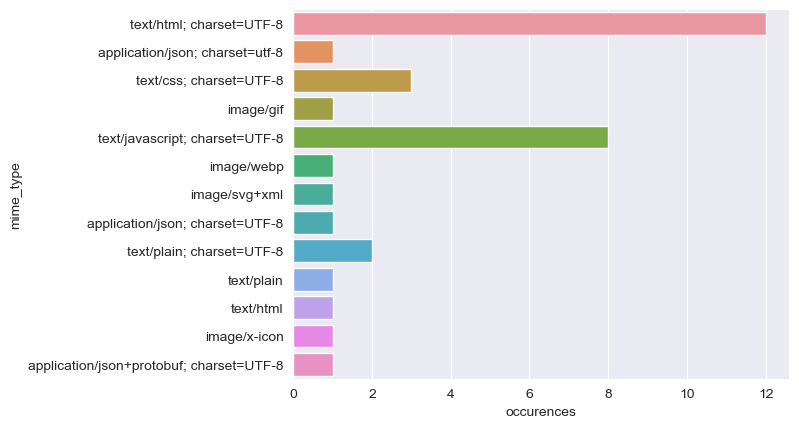

In [43]:
sns.barplot(data=google, x="occurences", y="mime_type")

<AxesSubplot:xlabel='occurences', ylabel='mime_type'>

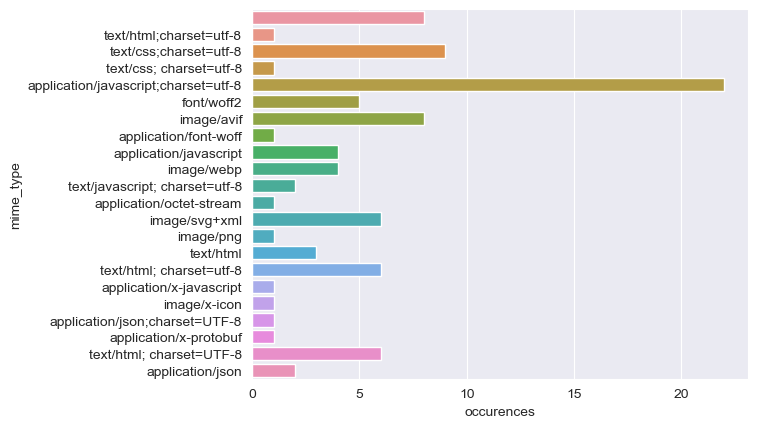

In [44]:
sns.barplot(data=microsoft, x="occurences", y="mime_type")

<AxesSubplot:xlabel='occurences', ylabel='mime_type'>

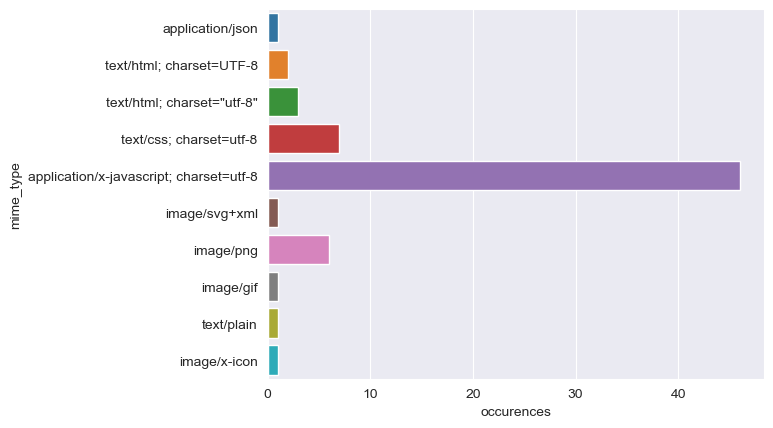

In [45]:
sns.barplot(data=facebook, x="occurences", y="mime_type")

<AxesSubplot:xlabel='occurences', ylabel='mime_type'>

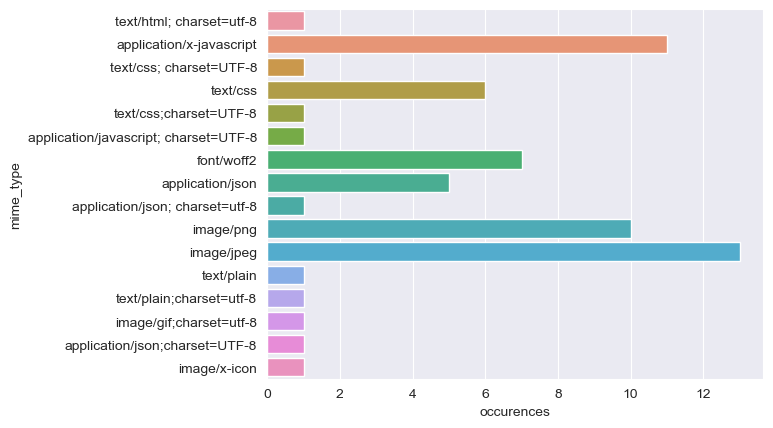

In [46]:
sns.barplot(data=apple, x="occurences", y="mime_type")

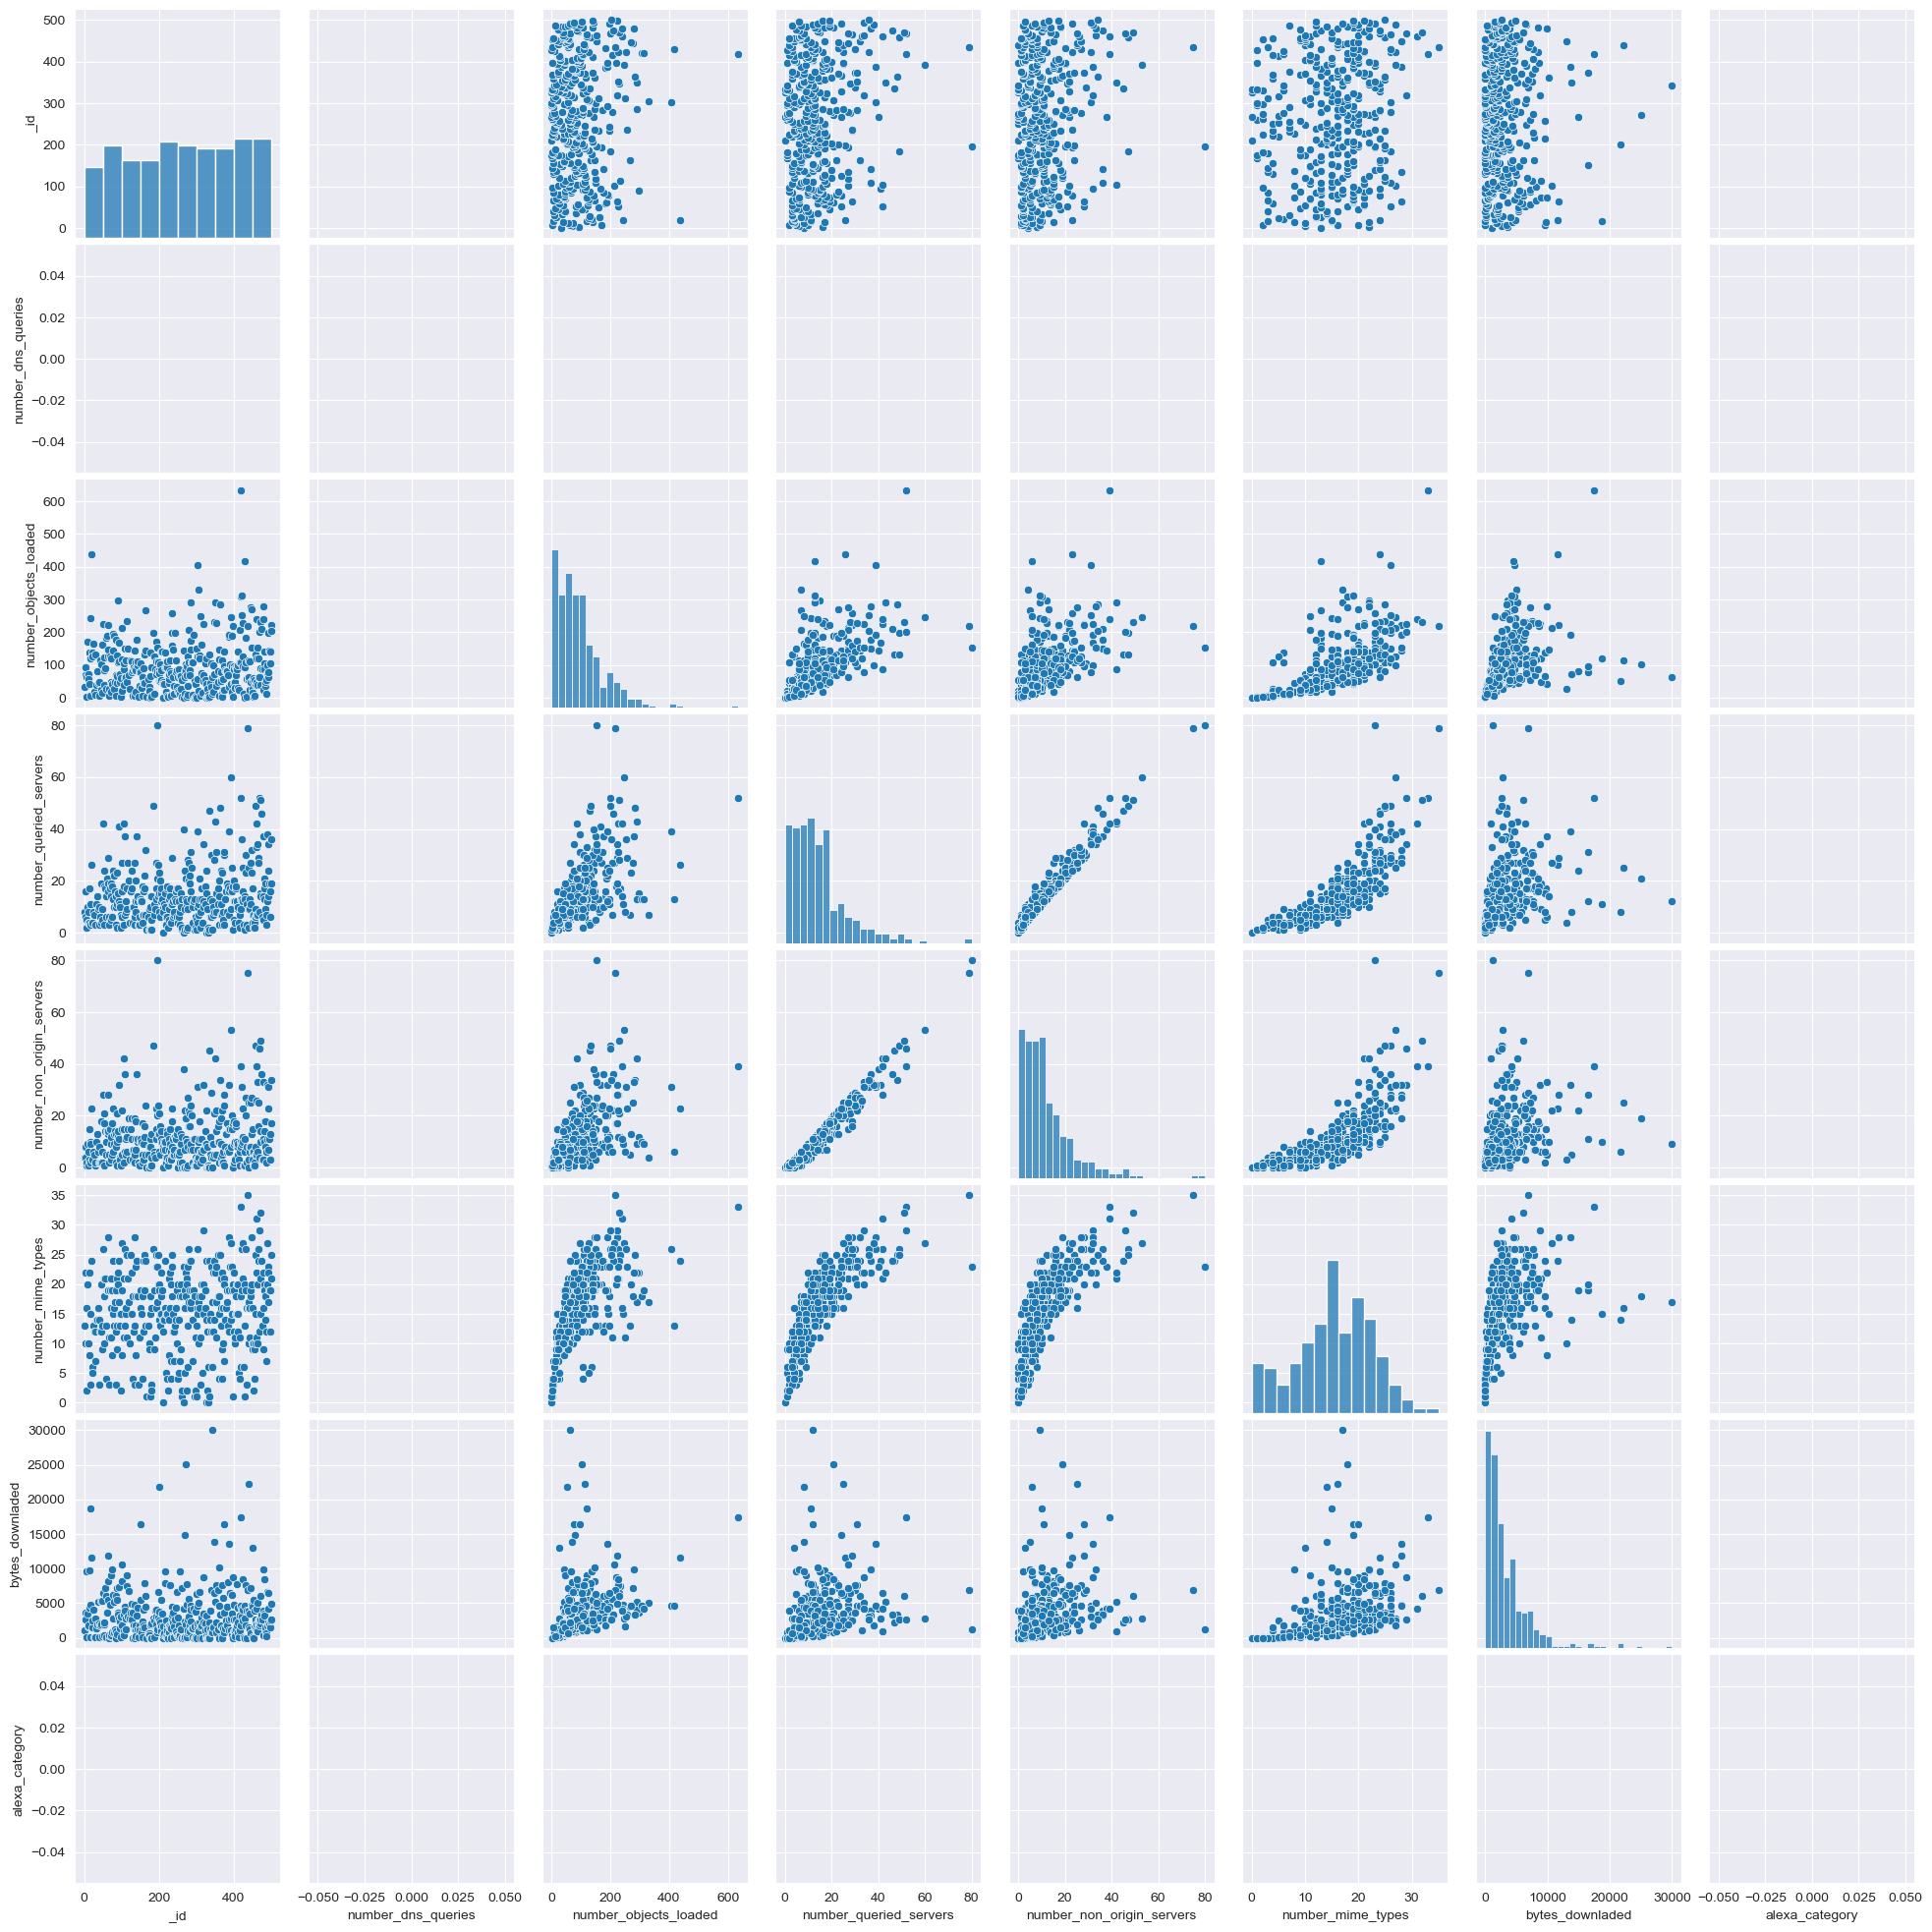

In [47]:
sns.pairplot(website_df, palette='Blues')